<a href="https://colab.research.google.com/github/mdzikrim/DeepLearning/blob/main/GRU_DeteksiSarkasme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
with open("/content/DeteksiSarkasme.json", "r") as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

def clean_text(text):
    text = re.sub(r"[^a-zA-Z']", " ", text)
    return text.lower()

texts = df['headline'].astype(str).apply(clean_text).tolist()
labels = df['is_sarcastic'].values

tokenized = [word_tokenize(t) for t in texts]
all_words = [word for tokens in tokenized for word in tokens]
vocab = ['<PAD>', '<UNK>'] + [w for w, _ in Counter(all_words).most_common(10000)]
word2idx = {word: idx for idx, word in enumerate(vocab)}

def encode(text, max_len=40):
    tokens = word_tokenize(text)
    encoded = [word2idx.get(w, word2idx['<UNK>']) for w in tokens][:max_len]
    return encoded + [0] * (max_len - len(encoded))

encoded_texts = [encode(t) for t in texts]
X = torch.tensor(encoded_texts)
y = torch.tensor(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
class SarcasmDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(SarcasmDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(SarcasmDataset(X_test, y_test), batch_size=64)


In [8]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.gru(x)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        h_n = self.dropout(h_n)
        out = self.fc(h_n)
        return self.sigmoid(out).squeeze()


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GRUModel(vocab_size=len(vocab), embed_dim=64, hidden_dim=256).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_losses, train_accuracies = [], []

for epoch in range(15):
    model.train()
    epoch_loss = 0
    correct, total = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.float().to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = (outputs > 0.5).int()
        correct += (preds == y_batch.int()).sum().item()
        total += y_batch.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Accuracy: {acc:.4f}")
    train_losses.append(epoch_loss)
    train_accuracies.append(acc)


Epoch 1 | Loss: 169.4684 | Accuracy: 0.7386
Epoch 2 | Loss: 132.3987 | Accuracy: 0.8128
Epoch 3 | Loss: 105.3653 | Accuracy: 0.8602
Epoch 4 | Loss: 81.3531 | Accuracy: 0.8965
Epoch 5 | Loss: 58.0822 | Accuracy: 0.9321
Epoch 6 | Loss: 38.2396 | Accuracy: 0.9564
Epoch 7 | Loss: 22.2544 | Accuracy: 0.9769
Epoch 8 | Loss: 12.6580 | Accuracy: 0.9874
Epoch 9 | Loss: 7.7789 | Accuracy: 0.9925
Epoch 10 | Loss: 4.9423 | Accuracy: 0.9958
Epoch 11 | Loss: 4.3718 | Accuracy: 0.9959
Epoch 12 | Loss: 3.5715 | Accuracy: 0.9971
Epoch 13 | Loss: 3.9662 | Accuracy: 0.9964
Epoch 14 | Loss: 8.2051 | Accuracy: 0.9914
Epoch 15 | Loss: 4.9668 | Accuracy: 0.9950


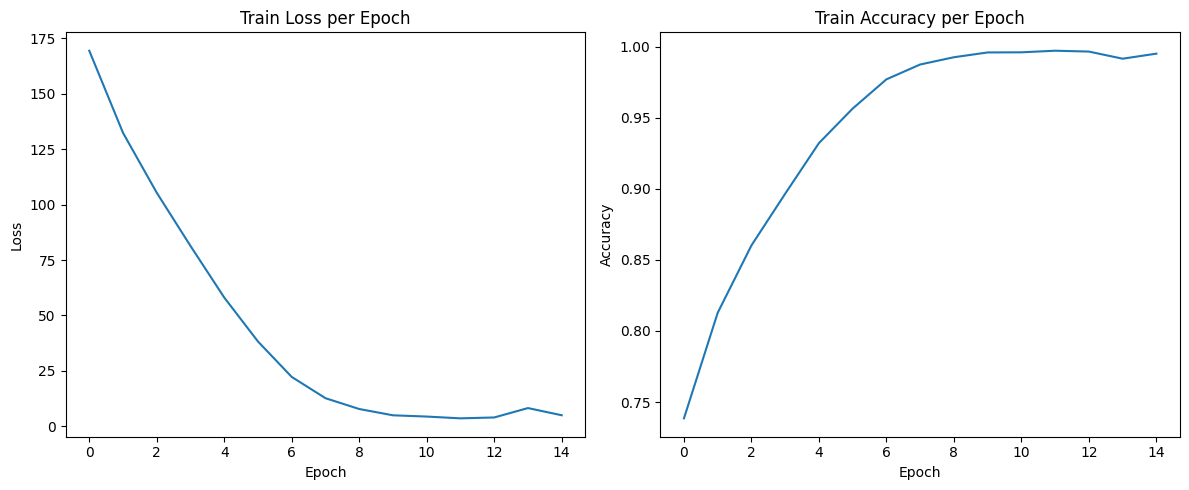

In [13]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Loss")
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Accuracy")
plt.title("Train Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [11]:
model.eval()
all_preds = []
all_probs = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = outputs.cpu().numpy()
        preds = (probs > 0.5).astype(int)

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_targets.extend(y_batch.numpy())

acc = accuracy_score(all_targets, all_preds)
prec = precision_score(all_targets, all_preds)
rec = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)
auc = roc_auc_score(all_targets, all_probs)

print("=== Evaluation on Test Set ===")
print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


=== Evaluation on Test Set ===
Akurasi  : 0.8484
Presisi  : 0.8271
Recall   : 0.8278
F1-Score : 0.8274
AUC      : 0.9234


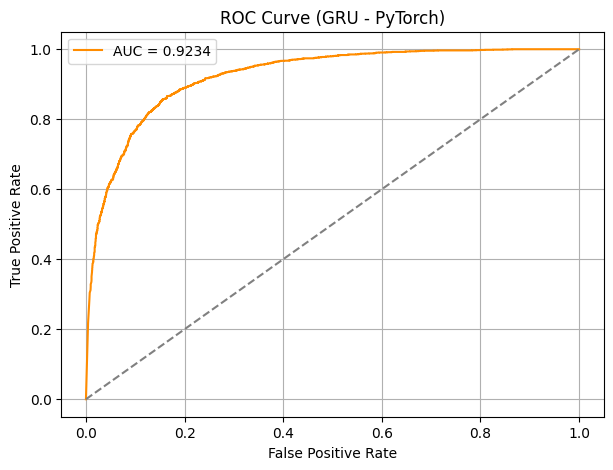

In [12]:
fpr, tpr, _ = roc_curve(all_targets, all_probs)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='darkorange')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title("ROC Curve (GRU - PyTorch)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


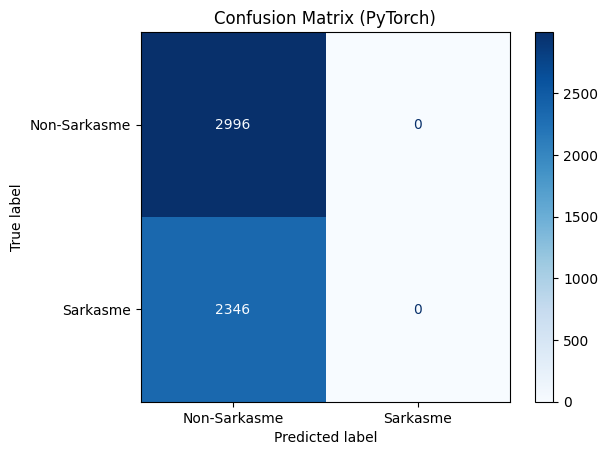

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Hitung Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Tampilkan Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Sarkasme", "Sarkasme"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (PyTorch)")
plt.grid(False)
plt.show()


In [16]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [17]:
import json
import re
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
# Load JSON
with open("/content/DeteksiSarkasme.json", "r") as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

# Preprocess teks
def clean_text(text):
    return re.sub(r"[^a-zA-Z']", " ", text).lower()

df['cleaned'] = df['headline'].apply(clean_text)

# Tokenisasi dan Padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned'])

sequences = tokenizer.texts_to_sequences(df['cleaned'])
padded = pad_sequences(sequences, maxlen=40, padding='post', truncating='post')

# Dataset
X = padded
y = np.array(df['is_sarcastic'])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(layers.Embedding(input_dim=10000,
                               output_dim=hp.Int("embed_dim", 32, 128, step=32),
                               input_length=40))
    model.add(layers.GRU(units=hp.Int("gru_units", 64, 256, step=64),
                         return_sequences=False))
    model.add(layers.Dropout(hp.Float("dropout", 0.2, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(
                      learning_rate=hp.Choice("lr", [1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [20]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
    directory="sarcasm_gru_tuning",
    project_name="sarcasm_gru"
)

tuner.search(X_train, y_train, epochs=5, validation_split=0.2, verbose=1)


Trial 5 Complete [00h 02m 07s]
val_accuracy: 0.5538137555122375

Best val_accuracy So Far: 0.5538137555122375
Total elapsed time: 00h 29m 05s


In [21]:
best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(X_train, y_train,
                         epochs=15,
                         batch_size=64,
                         validation_split=0.2,
                         verbose=1)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


268/268 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.5614 - loss: 0.6858 - val_accuracy: 0.5538 - val_loss: 0.6875
Epoch 2/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - accuracy: 0.5639 - loss: 0.6852 - val_accuracy: 0.5538 - val_loss: 0.6874
Epoch 3/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.5682 - loss: 0.6841 - val_accuracy: 0.5538 - val_loss: 0.6874
Epoch 4/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 26s 97ms/step - accuracy: 0.5591 - loss: 0.6864 - val_accuracy: 0.5538 - val_loss: 0.6876
Epoch 5/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - accuracy: 0.5644 - loss: 0.6850 - val_accuracy: 0.5538 - val_loss: 0.6873
Epoch 6/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - accuracy: 0.5679 - loss: 0.6841 - val_accuracy: 0.5538 - val_loss: 0.6874
Epoch 7/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - accuracy: 0.5625 - loss: 0.6855 - val_accuracy: 0.5538 - val_loss: 0.6874
Epoch 8/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - accuracy: 0.5656 - loss: 0.6846 - val_accu

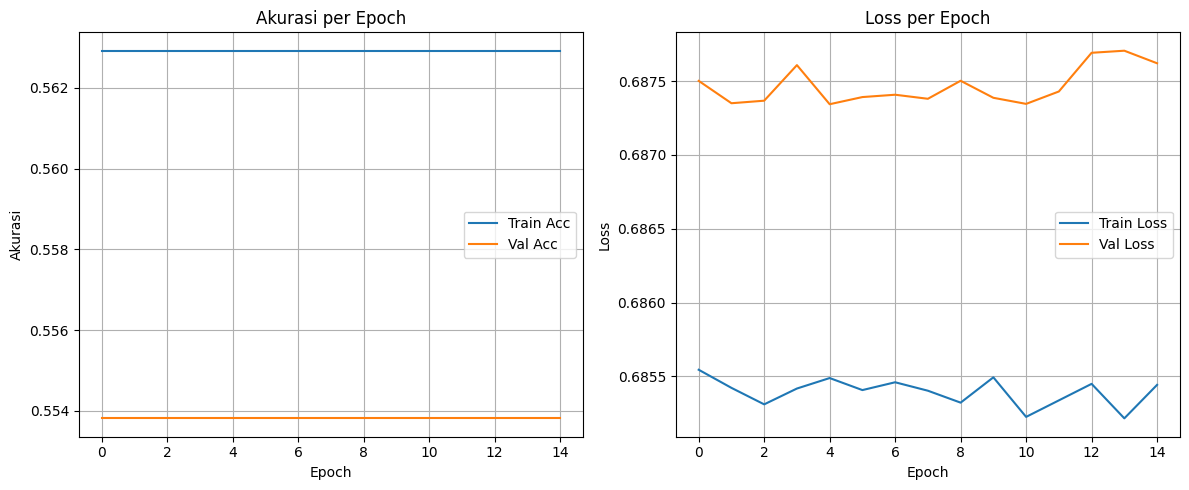

In [22]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Akurasi per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [23]:
# Prediksi
y_pred_probs = best_model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Evaluasi
print("Akurasi :", accuracy_score(y_test, y_pred))
print("Presisi :", precision_score(y_test, y_pred))
print("Recall  :", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("AUC     :", roc_auc_score(y_test, y_pred_probs))


167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Akurasi : 0.5608386372145264
Presisi : 0.0
Recall  : 0.0
F1-Score: 0.0
AUC     : 0.5366065666412847


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


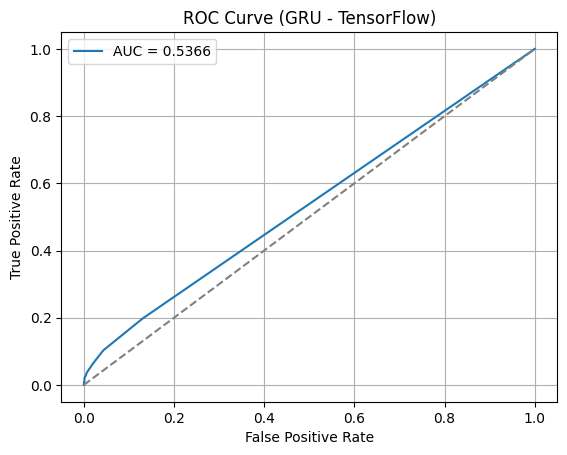

In [24]:
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)

plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(roc_auc_score(y_test, y_pred_probs)))
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (GRU - TensorFlow)')
plt.legend()
plt.grid()
plt.show()


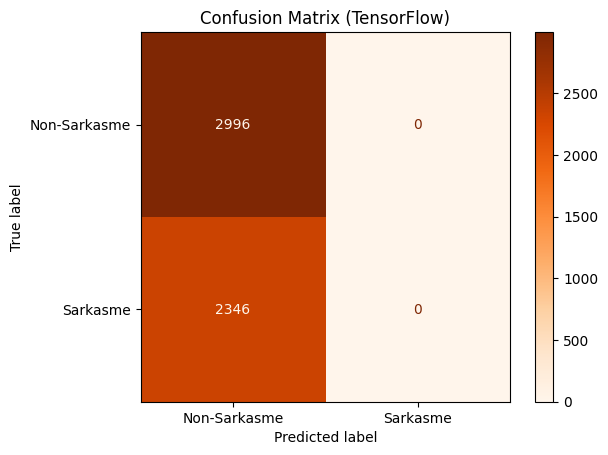

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_pred_probs sudah dari prediksi model sebelumnya
y_pred = (y_pred_probs > 0.5).astype(int)

# Hitung dan tampilkan Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Sarkasme", "Sarkasme"])
disp.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix (TensorFlow)")
plt.grid(False)
plt.show()
